In [11]:
import cv2
import os
import glob
from pathlib import Path
import pandas as pd
import shutil
import logging

## Images to video

In [ ]:

def create_video_from_images(image_folder, video_path, fps=25):
    # Get all image files in the folder
    image_files = [f for f in sorted(os.listdir(image_folder)) if f.endswith(('.png', '.jpg', '.jpeg'))]
    if not image_files:
        print(f"No images found in {image_folder}")
        return
    
    # Read the first image to get the size
    first_image_path = os.path.join(image_folder, image_files[0])
    frame = cv2.imread(first_image_path)
    if frame is None:
        print(f"Failed to read the first image from {first_image_path}")
        return
    
    height, width, _ = frame.shape
    print(f"Video dimensions: {width}x{height}")

    # Define the codec and create VideoWriter object
    codecs = ['mp4v', 'XVID', 'MJPG', 'H264']
    for codec in codecs:
        fourcc = cv2.VideoWriter_fourcc(*codec)
        out = cv2.VideoWriter(video_path, fourcc, fps, (width, height))
        if out.isOpened():
            print(f"Using codec: {codec}")
            break
    else:
        print(f"Failed to open video writer with codecs {codecs}")
        return

    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        frame = cv2.imread(image_path)
        if frame is None:
            print(f"Failed to read image {image_path}")
            continue
        out.write(frame)

    out.release()
    if os.path.exists(video_path):
        print(f"Video successfully saved to {video_path}")
    else:
        print(f"Failed to save video to {video_path}")

def process_all_folders(root_folder, output_folder):
    root_path = Path(root_folder)
    output_path = Path(output_folder)
    output_path.mkdir(parents=True, exist_ok=True)  # Create the output directory if it doesn't exist
    for sngs_folder in root_path.iterdir():
        if sngs_folder.is_dir():
            img1_folder = sngs_folder / 'img1'
            if img1_folder.exists() and img1_folder.is_dir():
                video_path = output_path / f"{sngs_folder.name}.mp4"
                print(f"Processing folder {img1_folder} and saving to {video_path}")
                create_video_from_images(img1_folder, str(video_path))
            else:
                print(f"No img1 folder found in {sngs_folder}")

# Set the root folder where 'train' folder is located
root_folder = "/Users/mathieu/Documents/soccernet/sn-gamestate/YOLO/murge/test"  # Change this to the correct path
output_folder = "/Users/mathieu/Documents/soccernet/sn-gamestate/YOLO/murge/video"  # Change this to your desired output path
process_all_folders(root_folder, output_folder)


## Convertir les fichier det.txt et gt.txt en yolo

In [ ]:
train_folder = "/Users/mathieu/Documents/SoccerNet/sn-gamestate/tracking/train"
test_folder = "/Users/mathieu/Documents/SoccerNet/sn-gamestate/tracking/test"
output_base_folder = "/Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/labels"

### Pour clean les dossiers :

In [79]:
import os
import shutil

def check_and_clear_directory(directory_path):
    # Vérifier si le chemin existe et est un répertoire
    if not os.path.exists(directory_path):
        print(f"Le chemin {directory_path} n'existe pas.")
        return

    if not os.path.isdir(directory_path):
        print(f"Le chemin {directory_path} n'est pas un répertoire.")
        return

    # Liste le contenu du répertoire
    files = os.listdir(directory_path)

    # Vérifie si le répertoire est vide
    if not files:
        print(f"Le répertoire {directory_path} est déjà vide.")
    else:
        # Supprime le contenu du répertoire
        for file in files:
            file_path = os.path.join(directory_path, file)
            try:
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)
                elif os.path.isdir(file_path):
                    shutil.rmtree(file_path)
            except Exception as e:
                print(f"Erreur lors de la suppression de {file_path}. Raison: {e}")
        print(f"Le contenu du répertoire {directory_path} a été supprimé.")

# Exemple d'utilisation
check_and_clear_directory("/Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/murge")
check_and_clear_directory("/Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/labels")
check_and_clear_directory("/Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/images")

Le répertoire /Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/murge est déjà vide.
Le contenu du répertoire /Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/labels a été supprimé.
Le contenu du répertoire /Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/images a été supprimé.


### Pour créer labels et images au format ultralytics (avec limite de fichier) : 

In [72]:
import os
import shutil
import logging
from collections import defaultdict

# Configuration du logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Dimensions de l'image
IMAGE_WIDTH = 1920
IMAGE_HEIGHT = 1080

# Limite du nombre de fichiers
MAX_FILES = 1000
TRAIN_FILES = 800
TEST_FILES = 200

# Dossiers de base
train_folder = "/Users/mathieu/Documents/SoccerNet/sn-gamestate/tracking/train"
test_folder = "/Users/mathieu/Documents/SoccerNet/sn-gamestate/tracking/test"
output_base_folder = "/Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/labels"
images_output_folder = "/Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/images"
train_output_folder = os.path.join(output_base_folder, "train")
test_output_folder = os.path.join(output_base_folder, "test")
train_images_output_folder = os.path.join(images_output_folder, "train")
test_images_output_folder = os.path.join(images_output_folder, "test")

# Créer les dossiers de sortie s'ils n'existent pas
os.makedirs(train_output_folder, exist_ok=True)
os.makedirs(test_output_folder, exist_ok=True)
os.makedirs(train_images_output_folder, exist_ok=True)
os.makedirs(test_images_output_folder, exist_ok=True)

def normalize_coordinates(x, y, w, h, img_width, img_height):
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    width = w / img_width
    height = h / img_height
    return x_center, y_center, width, height

def sort_lines_by_image_id(lines):
    # Fonction pour extraire le premier nombre d'une ligne
    def extract_first_number(line):
        return int(line.split(',')[0])
    
    # Trier les lignes par le premier nombre
    return sorted(lines, key=extract_first_number)

def process_file(input_file, current_index, train_files_count, test_files_count, subfolder, images_folder):
    #logging.info(f"Processing file: {input_file}")
    image_lines = defaultdict(list)
    with open(input_file, 'r') as file:
        lines = file.readlines()
    
    # Trier les lignes par l'ID d'image
    lines = sort_lines_by_image_id(lines)

    # Regrouper les lignes par ID d'image
    for line in lines:
        parts = line.strip().split(',')
        image_id = int(parts[0])
        x = float(parts[2])
        y = float(parts[3])
        w = float(parts[4])
        h = float(parts[5])
        class_id = 2  # Remplacez par la classe appropriée si nécessaire

        x_center, y_center, width, height = normalize_coordinates(x, y, w, h, IMAGE_WIDTH, IMAGE_HEIGHT)
        image_lines[image_id].append(f"{class_id} {x_center} {y_center} {width} {height}\n")

    # Écrire les données regroupées dans les fichiers de labels et copier les images
    for image_id, boxes in image_lines.items():
        if current_index > MAX_FILES:
            break
        label_file = os.path.join(output_base_folder, f"{current_index:06}.txt")  # Format 6 chiffres
        with open(label_file, 'w') as label:
            label.writelines(boxes)

        # Copier l'image correspondante
        image_file_name = f"{image_id:06}.jpg"  # Assuming the image files are in JPEG format
        src_image_path = os.path.join(images_folder, image_file_name)

        # Déterminer si le fichier doit aller dans train ou test
        if train_files_count < TRAIN_FILES:
            dest_label_path = os.path.join(train_output_folder, f"{current_index:06}.txt")
            dest_image_path = os.path.join(train_images_output_folder, f"{current_index:06}.jpg")
            train_files_count += 1
        else:
            dest_label_path = os.path.join(test_output_folder, f"{current_index:06}.txt")
            dest_image_path = os.path.join(test_images_output_folder, f"{current_index:06}.jpg")
            test_files_count += 1

        if os.path.exists(src_image_path):
            shutil.copy(src_image_path, dest_image_path)
        else:
            logging.warning(f"Image file {src_image_path} does not exist.")

        shutil.move(label_file, dest_label_path)
        #logging.info(f"The file {input_file} from folder {subfolder} generated the files {dest_label_path} and {dest_image_path}")
        current_index += 1

    return current_index, train_files_count, test_files_count

def process_subfolders(base_folder, start_index, train_files_count, test_files_count):
    #logging.info(f"Processing subfolders in: {base_folder}")
    current_index = start_index
    for subfolder in sorted(os.listdir(base_folder)):
        if current_index > MAX_FILES:
            break
        subfolder_path = os.path.join(base_folder, subfolder)
        if os.path.isdir(subfolder_path):
            #logging.info(f"Processing subfolder: {subfolder}")
            gt_folder = os.path.join(subfolder_path, 'gt')
            images_folder = os.path.join(subfolder_path, 'img1')  # Assumed folder for images

            if os.path.exists(gt_folder):
                gt_file = os.path.join(gt_folder, 'gt.txt')
                if os.path.exists(gt_file):
                    current_index, train_files_count, test_files_count = process_file(
                        gt_file, current_index, train_files_count, test_files_count, subfolder, images_folder)

    return current_index, train_files_count, test_files_count

# Process both train and test folders and merge into the labels folder
logging.info("Starting processing of train folder")
next_index = 1
train_files_count = 0
test_files_count = 0
next_index, train_files_count, test_files_count = process_subfolders(
    train_folder, next_index, train_files_count, test_files_count)
logging.info("Finished processing of train folder")

logging.info("Starting processing of test folder")
next_index, train_files_count, test_files_count = process_subfolders(
    test_folder, next_index, train_files_count, test_files_count)
logging.info("Finished processing of test folder")

logging.info("Conversion, fusion et division terminées.")


2024-06-21 14:39:17,692 - INFO - Starting processing of train folder
2024-06-21 14:39:20,388 - INFO - Finished processing of train folder
2024-06-21 14:39:20,389 - INFO - Starting processing of test folder
2024-06-21 14:39:20,391 - INFO - Finished processing of test folder
2024-06-21 14:39:20,392 - INFO - Conversion, fusion et division terminées.


### Pour créer labels et images au format ultralytics (sans limite de fichier) : 

In [81]:
import os
import shutil
import logging
from collections import defaultdict
from tqdm import tqdm

# Configuration du logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Dimensions de l'image
IMAGE_WIDTH = 1920
IMAGE_HEIGHT = 1080

# Dossiers de base
train_folder = "/Users/mathieu/Documents/SoccerNet/sn-gamestate/tracking/train"
test_folder = "/Users/mathieu/Documents/SoccerNet/sn-gamestate/tracking/test"
output_base_folder = "/Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/labels"
images_output_folder = "/Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/images"
train_output_folder = os.path.join(output_base_folder, "train")
test_output_folder = os.path.join(output_base_folder, "test")
train_images_output_folder = os.path.join(images_output_folder, "train")
test_images_output_folder = os.path.join(images_output_folder, "test")

# Créer les dossiers de sortie s'ils n'existent pas
os.makedirs(train_output_folder, exist_ok=True)
os.makedirs(test_output_folder, exist_ok=True)
os.makedirs(train_images_output_folder, exist_ok=True)
os.makedirs(test_images_output_folder, exist_ok=True)

def normalize_coordinates(x, y, w, h, img_width, img_height):
    x_center = (x + w / 2) / img_width
    y_center = (y + h / 2) / img_height
    width = w / img_width
    height = h / img_height
    return x_center, y_center, width, height

def sort_lines_by_image_id(lines):
    # Fonction pour extraire le premier nombre d'une ligne
    def extract_first_number(line):
        return int(line.split(',')[0])
    
    # Trier les lignes par le premier nombre
    return sorted(lines, key=extract_first_number)

def process_file(input_file, current_index, subfolder, images_folder, dest_label_folder, dest_image_folder):
    #logging.info(f"Processing file: {input_file}")
    image_lines = defaultdict(list)
    with open(input_file, 'r') as file:
        lines = file.readlines()
    
    # Trier les lignes par l'ID d'image
    lines = sort_lines_by_image_id(lines)

    # Regrouper les lignes par ID d'image
    for line in lines:
        parts = line.strip().split(',')
        image_id = int(parts[0])
        x = float(parts[2])
        y = float(parts[3])
        w = float(parts[4])
        h = float(parts[5])
        class_id = 2  # Remplacez par la classe appropriée si nécessaire

        x_center, y_center, width, height = normalize_coordinates(x, y, w, h, IMAGE_WIDTH, IMAGE_HEIGHT)
        image_lines[image_id].append(f"{class_id} {x_center} {y_center} {width} {height}\n")

    # Écrire les données regroupées dans les fichiers de labels et copier les images
    for image_id, boxes in image_lines.items():
        label_file = os.path.join(output_base_folder, f"{current_index:06}.txt")  # Format 6 chiffres
        with open(label_file, 'w') as label:
            label.writelines(boxes)

        # Copier l'image correspondante
        image_file_name = f"{image_id:06}.jpg"  # Assuming the image files are in JPEG format
        src_image_path = os.path.join(images_folder, image_file_name)
        dest_label_path = os.path.join(dest_label_folder, f"{current_index:06}.txt")
        dest_image_path = os.path.join(dest_image_folder, f"{current_index:06}.jpg")

        if os.path.exists(src_image_path):
            shutil.copy(src_image_path, dest_image_path)
        else:
            logging.warning(f"Image file {src_image_path} does not exist.")

        shutil.move(label_file, dest_label_path)
        #logging.info(f"The file {input_file} from folder {subfolder} generated the files {dest_label_path} and {dest_image_path}")
        current_index += 1

    return current_index

def process_subfolders(base_folder, start_index, dest_label_folder, dest_image_folder):
    #logging.info(f"Processing subfolders in: {base_folder}")
    current_index = start_index
    subfolders = sorted(os.listdir(base_folder))
    for subfolder in tqdm(subfolders, desc=f"Processing {os.path.basename(base_folder)}"):
        subfolder_path = os.path.join(base_folder, subfolder)
        if os.path.isdir(subfolder_path):
            #logging.info(f"Processing subfolder: {subfolder}")
            gt_folder = os.path.join(subfolder_path, 'gt')
            images_folder = os.path.join(subfolder_path, 'img1')  # Assumed folder for images

            if os.path.exists(gt_folder):
                gt_file = os.path.join(gt_folder, 'gt.txt')
                if os.path.exists(gt_file):
                    current_index = process_file(
                        gt_file, current_index, subfolder, images_folder, dest_label_folder, dest_image_folder)

    return current_index

# Process train and test folders separately and merge into the labels folder
logging.info("Starting processing of train folder")
next_index = 1
next_index = process_subfolders(train_folder, next_index, train_output_folder, train_images_output_folder)
logging.info("Finished processing of train folder")

logging.info("Starting processing of test folder")
next_index = process_subfolders(test_folder, next_index, test_output_folder, test_images_output_folder)
logging.info("Finished processing of test folder")

logging.info("Conversion, fusion et division terminées.")


2024-06-21 15:13:35,939 - INFO - Starting processing of train folder
Processing train: 100%|█████████████████████████| 58/58 [04:57<00:00,  5.14s/it]
2024-06-21 15:18:34,023 - INFO - Finished processing of train folder
2024-06-21 15:18:34,024 - INFO - Starting processing of test folder
Processing test: 100%|██████████████████████████| 50/50 [04:42<00:00,  5.65s/it]
2024-06-21 15:23:16,707 - INFO - Finished processing of test folder
2024-06-21 15:23:16,708 - INFO - Conversion, fusion et division terminées.


### Pour murge les images et les labels dans un dossier dédié 

In [ ]:
import os
import cv2
import logging
from tqdm import tqdm

# Configuration du logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

labels_base_folder = "/Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/labels"
images_base_folder = "/Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/images"
output_base_folder = "/Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/murge"
train_labels_folder = os.path.join(labels_base_folder, "train")
test_labels_folder = os.path.join(labels_base_folder, "test")
train_images_folder = os.path.join(images_base_folder, "train")
test_images_folder = os.path.join(images_base_folder, "test")
train_output_folder = os.path.join(output_base_folder, "train")
test_output_folder = os.path.join(output_base_folder, "test")

os.makedirs(train_output_folder, exist_ok=True)
os.makedirs(test_output_folder, exist_ok=True)

def draw_bounding_boxes(image_path, label_path, output_path):
    #logging.info(f"Drawing bounding boxes for image: {image_path} with labels: {label_path}")
    image = cv2.imread(image_path)
    height, width, _ = image.shape

    with open(label_path, 'r') as file:
        lines = file.readlines()

    for line in lines:
        parts = line.strip().split()
        class_id = int(parts[0])
        x_center = float(parts[1]) * width
        y_center = float(parts[2]) * height
        box_width = float(parts[3]) * width
        box_height = float(parts[4]) * height

        x1 = int(x_center - box_width / 2)
        y1 = int(y_center - box_height / 2)
        x2 = int(x_center + box_width / 2)
        y2 = int(y_center + box_height / 2)

        color = (0, 255, 0)  # Green color for bounding box
        cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)
        cv2.putText(image, str(class_id), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)

    cv2.imwrite(output_path, image)

def process_folder(images_folder, labels_folder, output_folder):
    image_files = sorted([f for f in os.listdir(images_folder) if f.endswith('.jpg')])
    label_files = sorted([f for f in os.listdir(labels_folder) if f.endswith('.txt')], key=lambda x: int(os.path.splitext(x)[0]))

    if len(image_files) != len(label_files):
        logging.warning("The number of images and labels do not match!")

    for image_file, label_file in tqdm(zip(image_files, label_files), total=len(image_files), desc=f"Processing {os.path.basename(images_folder)}"):
        image_path = os.path.join(images_folder, image_file)
        label_path = os.path.join(labels_folder, label_file)
        output_path = os.path.join(output_folder, image_file)

        #logging.info(f"Processing {image_file} and {label_file}")
        draw_bounding_boxes(image_path, label_path, output_path)

# Process train folders
logging.info("Processing train folders")
process_folder(train_images_folder, train_labels_folder, train_output_folder)
logging.info("Finished processing train folders")

# Process test folders
logging.info("Processing test folders")
process_folder(test_images_folder, test_labels_folder, test_output_folder)
logging.info("Finished processing test folders")

logging.info("Image annotation completed.")


2024-06-21 15:24:45,970 - INFO - Processing train folders
Processing train: 100%|███████████████████| 42750/42750 [46:16<00:00, 15.40it/s]
2024-06-21 16:11:03,499 - INFO - Finished processing train folders
2024-06-21 16:11:03,500 - INFO - Processing test folders
Processing test:  38%|███████▌            | 13902/36750 [14:38<28:29, 13.36it/s]

### Pour murge sur une image en particulier 

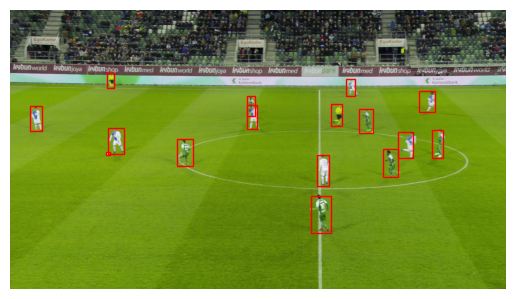

In [41]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

def annotate_image(image_path, labels_path):
    # Load the image
    image = Image.open(image_path)

    # Load the labels
    with open(labels_path, 'r') as file:
        labels = file.readlines()

    # Convert the labels to actual image coordinates
    image_width, image_height = image.size
    boxes = []

    for label in labels:
        parts = label.split()
        class_id = int(parts[0])
        x_center = float(parts[1]) * image_width
        y_center = float(parts[2]) * image_height
        width = float(parts[3]) * image_width
        height = float(parts[4]) * image_height
        x_min = x_center - width / 2
        y_min = y_center - height / 2
        boxes.append((x_min, y_min, width, height, class_id))

    # Plot the image with boxes
    fig, ax = plt.subplots(1)
    ax.imshow(image)

    # Add boxes to the image
    for box in boxes:
        x_min, y_min, width, height, class_id = box
        rect = patches.Rectangle((x_min, y_min), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    # Display the result
    plt.axis('off')
    plt.show()

# Example usage
image_path = '/Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/images/train/000073.jpg'
labels_path = '/Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/labels/train/000579.txt'
annotate_image(image_path, labels_path)


## Video to images

In [2]:

def extract_frames_from_video(video_path, output_folder, frame_rate=25):
    video_name = os.path.basename(video_path).split('.')[0]
    output_path = os.path.join(output_folder, video_name)
    
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    cap = cv2.VideoCapture(video_path)
    frame_count = 0
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    while frame_count < 750:
        ret, frame = cap.read()
        if not ret:
            break
        
        if frame_count < total_frames:
            frame_filename = os.path.join(output_path, f"frame_{frame_count + 1:04d}.jpg")
            cv2.imwrite(frame_filename, frame)
        
        frame_count += 1
    
    cap.release()

def process_videos_in_folder(videos_folder, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    for filename in os.listdir(videos_folder):
        if filename.endswith(".mp4") or filename.endswith(".avi"):
            video_path = os.path.join(videos_folder, filename)
            extract_frames_from_video(video_path, output_folder)
            print(f"Processed {filename}")

# Usage
videos_folder = '/Users/mathieu/Documents/SoccerTrack_dataset/wide_view/videos'
output_folder = '/Users/mathieu/Documents/SoccerTrack_dataset/wide_view/photos'
process_videos_in_folder(videos_folder, output_folder)


Processed F_20220220_1_1440_1470.mp4
Processed F_20220220_1_1680_1710.mp4
Processed F_20200220_1_0300_0330.mp4
Processed F_20220220_1_1590_1620.mp4
Processed F_20220220_1_1050_1080.mp4
Processed F_20220220_1_1410_1440.mp4
Processed F_20220220_1_1290_1320.mp4
Processed F_20220220_1_1950_1980.mp4
Processed F_20220220_1_1860_1890.mp4
Processed F_20220220_1_1830_1860.mp4
Processed F_20200220_1_0180_0210.mp4
Processed F_20200220_1_0780_0810.mp4
Processed F_20220220_1_0990_1020.mp4
Processed F_20200220_1_0570_0600.mp4


KeyboardInterrupt: 

## CSV to txt

In [4]:

def convert_csv_to_txt(csv_folder, txt_folder):
    if not os.path.exists(txt_folder):
        os.makedirs(txt_folder)
    
    for csv_filename in os.listdir(csv_folder):
        if csv_filename.endswith(".csv"):
            csv_path = os.path.join(csv_folder, csv_filename)
            csv_data = pd.read_csv(csv_path)
            
            video_name = os.path.basename(csv_filename).split('.')[0]
            video_txt_folder = os.path.join(txt_folder, video_name)
            
            if not os.path.exists(video_txt_folder):
                os.makedirs(video_txt_folder)
            
            for index, row in csv_data.iterrows():
                frame_number = index + 1  # Assuming 1-based frame indexing
                txt_filename = f"frame_{frame_number:04d}.txt"
                txt_path = os.path.join(video_txt_folder, txt_filename)
                
                with open(txt_path, 'w') as txt_file:
                    row_data = row.to_string(index=False, header=False)
                    txt_file.write(row_data)
            
            print(f"Processed {csv_filename}")

# Usage
csv_folder = '/Users/mathieu/Documents/SoccerTrack_dataset/wide_view/annotations'
txt_folder = '/Users/mathieu/Documents/SoccerTrack_dataset/wide_view/annotations_texte'
convert_csv_to_txt(csv_folder, txt_folder)


Processed F_20220220_1_1050_1080.csv
Processed F_20220220_1_1590_1620.csv
Processed F_20200220_1_0300_0330.csv
Processed F_20220220_1_1680_1710.csv
Processed F_20220220_1_1440_1470.csv
Processed F_20220220_1_1830_1860.csv
Processed F_20220220_1_1950_1980.csv
Processed F_20220220_1_1860_1890.csv
Processed F_20220220_1_1290_1320.csv
Processed F_20220220_1_1410_1440.csv
Processed F_20200220_1_0570_0600.csv
Processed F_20220220_1_0990_1020.csv
Processed F_20200220_1_0780_0810.csv
Processed F_20200220_1_0180_0210.csv
Processed F_20200220_1_0270_0300.csv
Processed F_20200220_1_0660_0690.csv
Processed F_20200220_1_0750_0780.csv
Processed F_20200220_1_0630_0660.csv


KeyboardInterrupt: 

In [22]:
def filter_lines(input_file, output_file):
    with open(input_file, 'r') as infile, open(output_file, 'w') as outfile:
        for line in infile:
            if line.startswith('73,'):
                outfile.write(line)

# Exemple d'utilisation
input_file = '/Users/mathieu/Documents/SoccerNet/sn-gamestate/tracking/train/SNMOT-060/gt/gt.txt'
output_file = '/Users/mathieu/Documents/SoccerNet/sn-gamestate/tracking/train/SNMOT-060/gt/gt2txt'
filter_lines(input_file, output_file)


In [25]:
def convert_to_yolov8(input_file, output_file, img_width, img_height):
    """
    Convertit un fichier d'annotations au format Ultralytics pour YOLOv8 et les enregistre dans un fichier.
    
    Parameters:
    - input_file: Chemin vers le fichier .txt contenant les annotations.
    - output_file: Chemin vers le fichier .txt où enregistrer les annotations converties.
    - img_width: Largeur de l'image.
    - img_height: Hauteur de l'image.
    
    Returns:
    - None
    """
    def normalize_coordinates(x, y, w, h, img_width, img_height):
        x_center = (x + w / 2) / img_width
        y_center = (y + h / 2) / img_height
        width = w / img_width
        height = h / img_height
        return x_center, y_center, width, height

    yolov8_annotations = []

    with open(input_file, 'r') as file:
        lines = file.readlines()

    for line in lines:
        parts = line.strip().split(',')
        image_id = parts[0]
        class_id = 2  # Remplacez par la classe appropriée si nécessaire
        x = float(parts[2])
        y = float(parts[3])
        w = float(parts[4])
        h = float(parts[5])

        x_center, y_center, width, height = normalize_coordinates(x, y, w, h, img_width, img_height)
        yolov8_annotations.append(f"{class_id} {x_center} {y_center} {width} {height}")

    with open(output_file, 'w') as file:
        for annotation in yolov8_annotations:
            file.write(f"{annotation}\n")

# Exemple d'utilisation:
input_file = "/Users/mathieu/Documents/SoccerNet/sn-gamestate/tracking/train/SNMOT-060/gt/gt.txt"
output_file = "/Users/mathieu/Documents/SoccerNet/sn-gamestate/tracking/train/SNMOT-060/gt/yolov8_annotations.txt"
img_width = 1920
img_height = 1080
convert_to_yolov8(input_file, output_file, img_width, img_height)


### Verifier si deux fichier texte sont identiques : 

In [18]:
def compare_files(file1_path, file2_path):
    try:
        with open(file1_path, 'r') as file1, open(file2_path, 'r') as file2:
            file1_content = file1.read()
            file2_content = file2.read()

        if file1_content == file2_content:
            return "Les fichiers sont identiques."
        else:
            return "Les fichiers sont différents."
    except Exception as e:
        return f"Une erreur est survenue: {e}"

# Exemple d'utilisation
file1_path = '/Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO2/train/labels/000000.txt'
file2_path = '/Users/mathieu/Documents/SoccerNet/sn-gamestate/YOLO/labels/train/000001.txt'

result = compare_files(file1_path, file2_path)
print(result)


Les fichiers sont identiques.
